In [14]:
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import math

### Calculate Historical Realized Volatility

In [4]:
# Specify ticker symbol, time, and time period label

symbol = "CVNA"
time_period = '3 Years'
end_date = datetime.now()
start_date = end_date - timedelta(days=3 * 365)
historical_data = yf.download(symbol, start=start_date, end=end_date)
selected_columns = historical_data[['Open', 'High', 'Low', 'Close']]
selected_columns = selected_columns[::-1]
selected_columns['Date'] = selected_columns.index.strftime('%Y-%m-%d')
selected_columns = selected_columns[['Date', 'Open', 'High', 'Low', 'Close']]
selected_columns.to_csv(f'{symbol}_historical_data.csv', index=False)
print(f'{symbol} Data saved to {symbol}_historical_data.csv')

# Save data to csv file
dataframe = pd.read_csv('/Users/jackkeim/CVNA_historical_data.csv')
dataframe.head()

[*********************100%%**********************]  1 of 1 completed
CVNA Data saved to CVNA_historical_data.csv


,Date,Open,High,Low,Close
0,2024-01-11,45.750000,46.700001,43.290001,46.040001
1,2024-01-10,46.730000,47.279999,44.639999,46.740002
2,2024-01-09,47.009998,48.740002,46.349998,47.160000
3,2024-01-08,46.740002,49.029999,46.310001,48.330002
4,2024-01-05,45.169998,48.369999,44.500000,46.869999


In [9]:
dataframe['Date'] = pd.to_datetime(dataframe['Date'])
dataframe['Returns'] = dataframe['Close'].pct_change()

data_by_year = {}
for year in range(dataframe['Date'].dt.year.min(), dataframe['Date'].dt.year.max() + 1):
    data_by_year[year] = dataframe[dataframe['Date'].dt.year == year]

# Specify years in dataset

year1_data = data_by_year[2021]
year2_data = data_by_year[2022]
year3_data = data_by_year[2023]

for year, data in data_by_year.items():
    data = data.copy()  # Create a copy of the DataFrame before making modifications

    for period in [1, 2, 3, 4]:  # specify periods in weeks
        window_size = period * 5  # 5 trading days in a week

        # Close-to-Close volatility
        volatility_column = f'Volatility_{period}Week_CloseToClose'
        data.loc[:, volatility_column] = data['Returns'].rolling(window=window_size).std() * (window_size ** 0.5)

        # Parkinson volatility
        volatility_parkinson_column = f'Volatility_{period}Week_Parkinson'
        data.loc[:, volatility_parkinson_column] = (
            (1 / (4 * np.log(2))) * np.log(data['High'] / data['Low']).rolling(window=window_size).std()
        )

        # Garman and Klass volatility
        volatility_gk_column = f'Volatility_{period}Week_GarmanKlass'
        data.loc[:, volatility_gk_column] = (
            0.5 * (
                np.log(data['High'] / data['Low']) ** 2 -
                (2 * np.log(2) - 1) * (np.log(data['Close'] / data['Open']) ** 2)
            )
        ).rolling(window=window_size).mean() ** 0.5

        # Rogers and Satchell volatility
        volatility_rs_column = f'Volatility_{period}Week_RogersSatchell'
        data.loc[:, volatility_rs_column] = (
            np.log(data['Close'] / data['Open']) ** 2 - (1 / window_size) * (np.log(data['Close'] / data['Open']) ** 2)
        ).rolling(window=window_size).sum() ** 0.5

        # Yang and Zhang volatility
        volatility_yz_column = f'Volatility_{period}Week_YangZhang'
        data.loc[:, volatility_yz_column] = (
            (1 / (window_size - 1)) * (np.log(data['High'] / data['Low']) ** 2 - 2 * np.log(2) *
                                       np.log(data['Close'] / data['Open']) ** 2)
        ).rolling(window=window_size).sum() ** 0.5

    data_by_year[year] = data  # Update the original data_by_year dictionary with the modified copy
    
# Create an empty DataFrame to store the results
result_table = pd.DataFrame()

# Iterate through each year and estimator, concatenate DataFrames along columns
for year, data in data_by_year.items():
    for period in [1, 2, 3, 4]:
        volatility_column_close_to_close = f'Volatility_{period}Week_CloseToClose'
        volatility_column_parkinson = f'Volatility_{period}Week_Parkinson'
        volatility_column_gk = f'Volatility_{period}Week_GarmanKlass'
        volatility_column_rs = f'Volatility_{period}Week_RogersSatchell'
        volatility_column_yz = f'Volatility_{period}Week_YangZhang'

        # Extract the relevant volatilities for the current year and period
        volatilities = data[[volatility_column_close_to_close, volatility_column_parkinson,
                             volatility_column_gk, volatility_column_rs, volatility_column_yz]]

        # Rename columns to include the year and period
        volatilities.columns = [f'{year}_{period}_' + col for col in volatilities.columns]

        # Concatenate the volatilities along columns
        result_table = pd.concat([result_table, volatilities], axis=1)

# Save the result_table to a CSV file
result_table.to_csv(f'{symbol}_vol_data.csv', index=False)
# Adjust CSV file Name to match inputs
pd.read_csv(f'/Users/jackkeim/{symbol}_vol_data.csv')

,2021_1_Volatility_1Week_CloseToClose,2021_1_Volatility_1Week_Parkinson,2021_1_Volatility_1Week_GarmanKlass,2021_1_Volatility_1Week_RogersSatchell,2021_1_Volatility_1Week_YangZhang,2021_2_Volatility_2Week_CloseToClose,2021_2_Volatility_2Week_Parkinson,2021_2_Volatility_2Week_GarmanKlass,2021_2_Volatility_2Week_RogersSatchell,2021_2_Volatility_2Week_YangZhang,...,2024_3_Volatility_3Week_CloseToClose,2024_3_Volatility_3Week_Parkinson,2024_3_Volatility_3Week_GarmanKlass,2024_3_Volatility_3Week_RogersSatchell,2024_3_Volatility_3Week_YangZhang,2024_4_Volatility_4Week_CloseToClose,2024_4_Volatility_4Week_Parkinson,2024_4_Volatility_4Week_GarmanKlass,2024_4_Volatility_4Week_RogersSatchell,2024_4_Volatility_4Week_YangZhang
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.06615,0.003351,0.028012,0.054888,0.03194,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
751,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
752,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
753,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


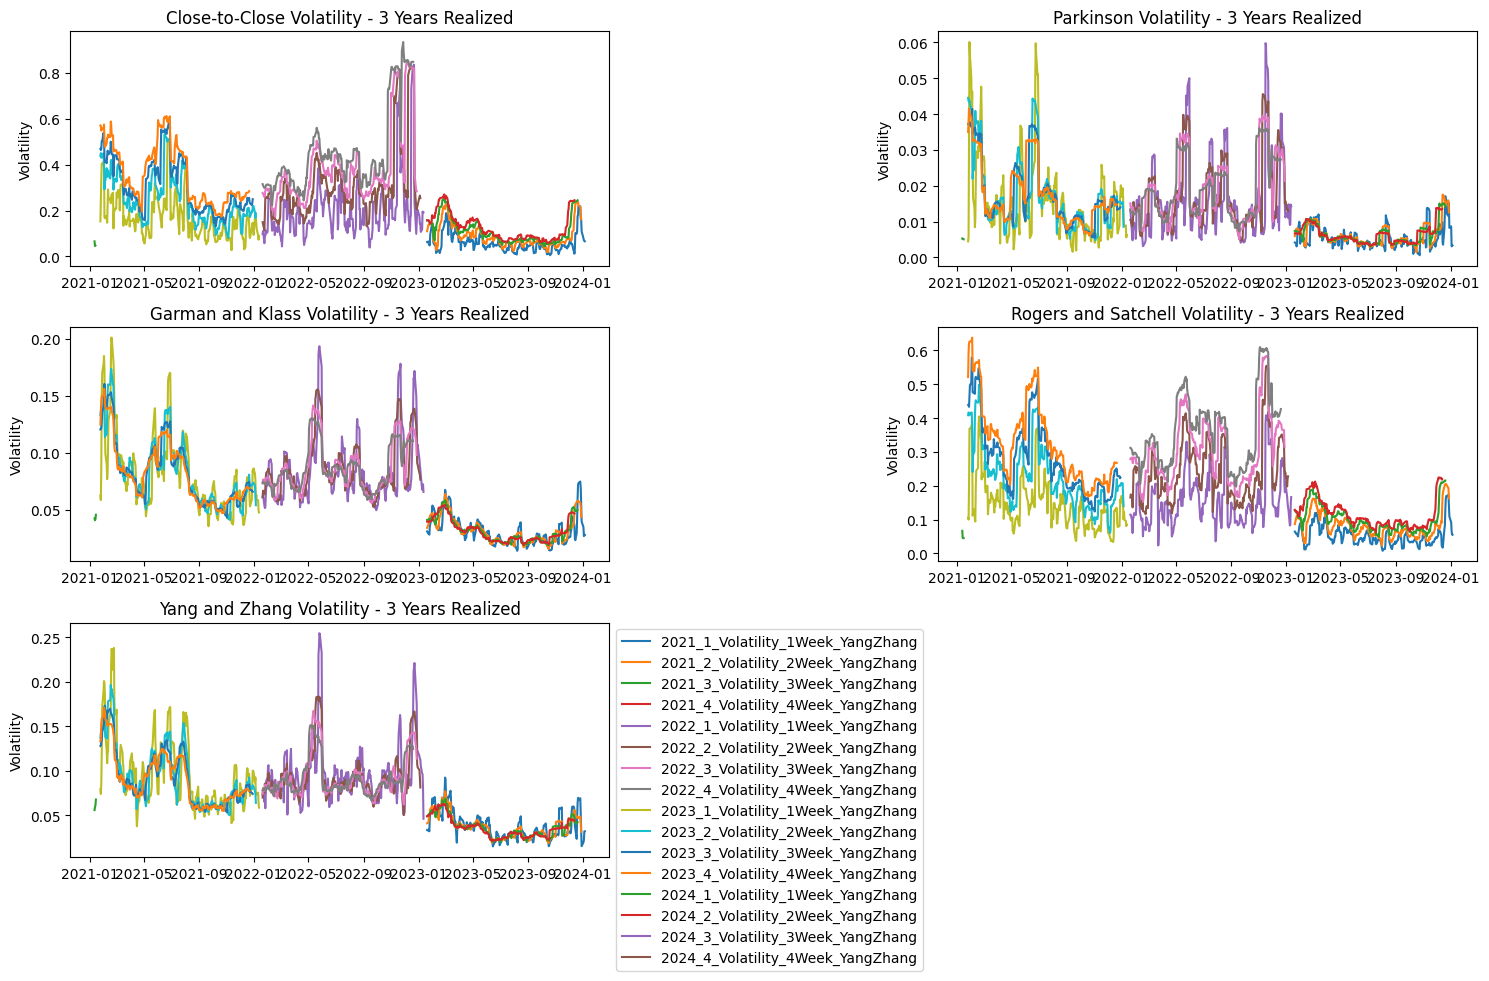

In [10]:
# Extract the column names for each estimator
close_to_close_columns = [col for col in result_table.columns if 'CloseToClose' in col]
parkinson_columns = [col for col in result_table.columns if 'Parkinson' in col]
gk_columns = [col for col in result_table.columns if 'GarmanKlass' in col]
rs_columns = [col for col in result_table.columns if 'RogersSatchell' in col]
yz_columns = [col for col in result_table.columns if 'YangZhang' in col]

# Plotting all volatilities side by side
plt.figure(figsize=(15, 10))

# Close-to-Close volatilities
plt.subplot(3, 2, 1)
for col in close_to_close_columns:
    plt.plot(dataframe['Date'], result_table[col], label=col)
plt.title(f'Close-to-Close Volatility - {time_period} Realized')
plt.ylabel('Volatility')

# Parkinson volatilities
plt.subplot(3, 2, 2)
for col in parkinson_columns:
    plt.plot(dataframe['Date'], result_table[col], label=col)
plt.title(f'Parkinson Volatility - {time_period} Realized')
plt.ylabel('Volatility')

# Garman and Klass volatilities
plt.subplot(3, 2, 3)
for col in gk_columns:
    plt.plot(dataframe['Date'], result_table[col], label=col)
plt.title(f'Garman and Klass Volatility - {time_period} Realized')
plt.ylabel('Volatility')

# Rogers and Satchell volatilities
plt.subplot(3, 2, 4)
for col in rs_columns:
    plt.plot(dataframe['Date'], result_table[col], label=col)
plt.title(f'Rogers and Satchell Volatility - {time_period} Realized')
plt.ylabel('Volatility')

# Yang and Zhang volatilities
plt.subplot(3, 2, 5)
for col in yz_columns:
    plt.plot(dataframe['Date'], result_table[col], label=col)
plt.title(f'Yang and Zhang Volatility - {time_period} Realized')
plt.ylabel('Volatility')

# Create a single legend for all plots
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()

[*********************100%%**********************]  1 of 1 completed
CVNA Data saved to CVNA_historical_data.csv


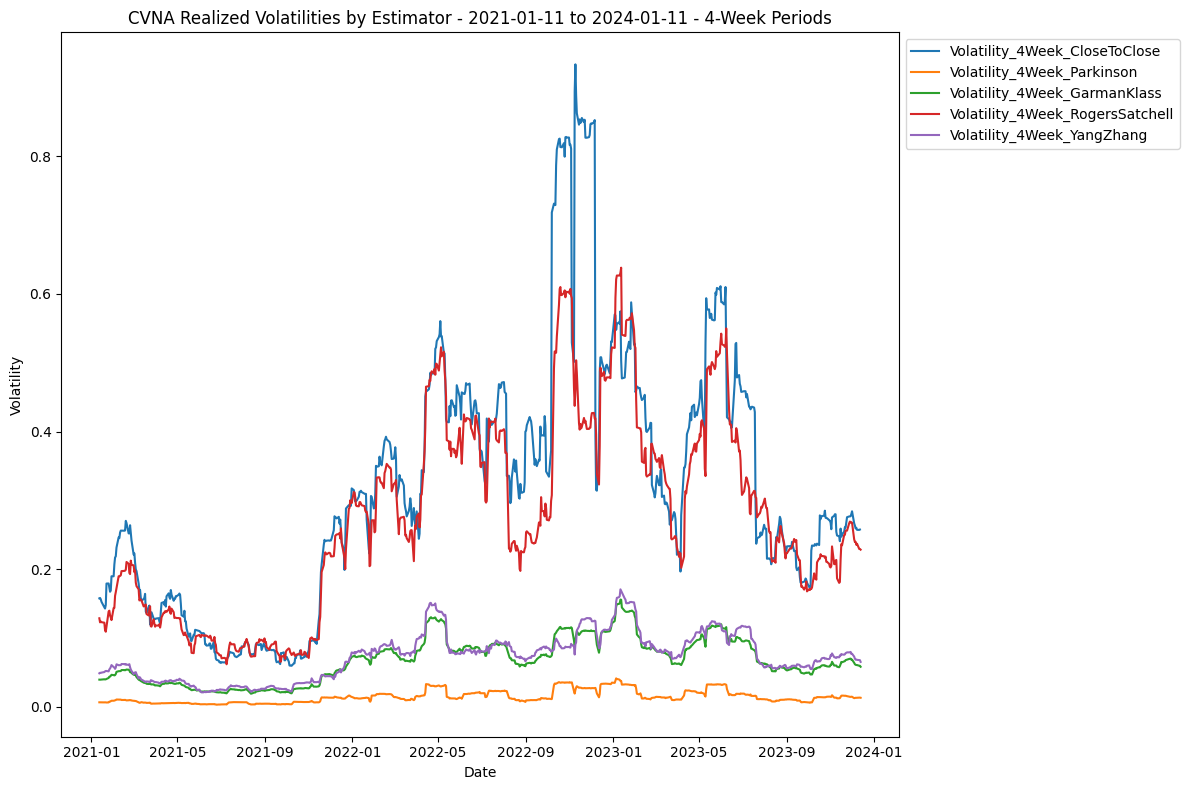

In [12]:
def plot_volatility_length(symbol, start_date, end_date, selected_length):
    # Download historical data
    historical_data = yf.download(symbol, start=start_date, end=end_date)
    selected_columns = historical_data[['Open', 'High', 'Low', 'Close']]
    selected_columns = selected_columns[::-1]
    selected_columns['Date'] = selected_columns.index.strftime('%Y-%m-%d')
    selected_columns = selected_columns[['Date', 'Open', 'High', 'Low', 'Close']]
    selected_columns.to_csv(f'{symbol}_historical_data.csv', index=False)
    print(f'{symbol} Data saved to {symbol}_historical_data.csv')

    # Adjust csv file-path to match inputs
    dataframe = pd.read_csv(f'{symbol}_historical_data.csv')
    dataframe['Date'] = pd.to_datetime(dataframe['Date'])
    dataframe['Returns'] = dataframe['Close'].pct_change()

    # Calculate volatilities
    result_table = pd.DataFrame()

    # Adjusted loop to consider only the specified length
    for period in [selected_length]:
        window_size = period * 5

        volatility_column_close_to_close = f'Volatility_{period}Week_CloseToClose'
        volatility_column_parkinson = f'Volatility_{period}Week_Parkinson'
        volatility_column_gk = f'Volatility_{period}Week_GarmanKlass'
        volatility_column_rs = f'Volatility_{period}Week_RogersSatchell'
        volatility_column_yz = f'Volatility_{period}Week_YangZhang'

        result_table[volatility_column_close_to_close] = (
            dataframe['Returns'].rolling(window=window_size).std() * (window_size ** 0.5)
        )

        result_table[volatility_column_parkinson] = (
            (1 / (4 * np.log(2))) * np.log(dataframe['High'] / dataframe['Low']).rolling(window=window_size).std()
        )

        result_table[volatility_column_gk] = (
            0.5 * (
                np.log(dataframe['High'] / dataframe['Low']) ** 2 -
                (2 * np.log(2) - 1) * (np.log(dataframe['Close'] / dataframe['Open']) ** 2)
            )
        ).rolling(window=window_size).mean() ** 0.5

        result_table[volatility_column_rs] = (
            np.log(dataframe['Close'] / dataframe['Open']) ** 2 - (1 / window_size) *
            (np.log(dataframe['Close'] / dataframe['Open']) ** 2)
        ).rolling(window=window_size).sum() ** 0.5

        result_table[volatility_column_yz] = (
            (1 / (window_size - 1)) * (
                np.log(dataframe['High'] / dataframe['Low']) ** 2 - 2 * np.log(2) *
                np.log(dataframe['Close'] / dataframe['Open']) ** 2
            )
        ).rolling(window=window_size).sum() ** 0.5

    plt.figure(figsize=(12, 8))

    for col in result_table.columns:
        plt.plot(dataframe['Date'], result_table[col], label=col)

    plt.title(f'{symbol} Realized Volatilities by Estimator - {start_date.date()} to {end_date.date()} - {selected_length}-Week Periods')
    plt.xlabel('Date')
    plt.ylabel('Volatility')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.show()

# Example usage:
start_date = datetime.now() - timedelta(days=3 * 365)
end_date = datetime.now()
selected_length = 4  # Specify the desired length (1, 2, 3, or 4)
plot_volatility_length(f"{symbol}", start_date, end_date, selected_length)

# Analysis
### Comparing Implied Volatility to Realized Volatility 

### Evaluating Estimators

#### Close-to-Close:
Definition: Close-to-Close volatility, also known as historical volatility, is a measure of price variability over a specific historical period. It is calculated by analyzing the daily closing prices of an asset or security.
Measurement: To calculate Close-to-Close volatility, you would typically compute the daily returns (percentage changes) based on closing prices and then calculate the standard deviation of these returns over the historical period. A higher standard deviation indicates higher volatility.

#### Parkinson:
Definition: Parkinson volatility is a measure of intraday price fluctuations within a trading session. It is named after its creator, Michael Parkinson, and it focuses on the high and low prices of the day.
Measurement: It considers price range rather than closing prices.

#### Garman & Klass:
Definition: The Garman & Klass volatility is another intraday volatility estimator designed to measure price fluctuations within a trading day. It takes into account open, high, low, and close prices.
Measurement: The formula for Garman & Klass volatility is more complex but includes the open, high, low, and close prices. It is calculated as a weighted average of different price ranges within the trading session, providing a more comprehensive view of intraday volatility.

#### Rogers & Satchell:
Definition: The Rogers & Satchell volatility estimator is a variation of the historical volatility calculation that includes the high and low prices in addition to closing prices. It is designed to capture both intraday and interday volatility.
Measurement: To calculate Rogers & Satchell volatility, you would use a formula that considers the daily returns based on open, high, low, and close prices. It aims to provide a more robust measure of volatility than the Close-to-Close method.

#### Yang & Zhang:
Definition: The Yang & Zhang volatility estimator is a variation of historical volatility that uses the logarithm of daily returns and a weighted sum of high and low prices. It is designed to address potential biases in traditional volatility measures.
Measurement: This method calculates volatility by incorporating the logarithm of daily returns and using weights for high and low prices. It aims to provide a more accurate measure of volatility, especially when there are gaps or jumps in prices.